### Topic Significance Ranking
- Based on: [Topic Significance Ranking of LDA Generative Models (Alsumait et al.)](https://mimno.infosci.cornell.edu/info6150/readings/ECML09_AlSumaitetal.pdf).
- Data aquisition from [this website](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#3importnewsgroupstextdata) verbatum, with prints removed.


In [1]:
import numpy as np
from scipy.stats import entropy
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize


def TopicSignificanceRanking(count_vector, components, documents):
    '''
    This takes the topics from an LDA model (sklearn) and assigns TSR scores to it.
    
        count_vector: the count vector of the words used in the sklearn model.
    
        components:   the topics generated by the LDA model.
        
        RETURNS Psi and S for each topic (where TSR = Psi x S)
        
    It is highly probable that this could be done easier than below, and indeed, highly likely.  I was doing this as I read through the paper, and therefore was thinking in terms of matching the text, not in terms of efficiency, except where blindingly obvious.
    Darin LaSota, 5/30/2018
    '''
    # Turn components into word topic dist
    components = components/components.sum(axis=1)[:, np.newaxis]

    # Derived Quantities
    topics = components.shape[0]  # number of topics
    measures = 3
    measure = ['KL','COR','COS']
    
    # Distributions...
    # W-Uniform is a junk topic in which all the terms of the dictionary are equally probable
    W_Uniform = np.ones(components.shape)/components.shape[1]
    
    # the vacuous semantic distribution (W_Vacuous), is deﬁned to be the empirical distribution of the sample set
    # p(w|W_Vacuous) = Sum Over all Topics, k of p(w|k)p(k)
    W_Vacuous = np.zeros(components.shape)
    p_k = np.sum(documents, axis=0)/np.sum(documents)
    temp = np.zeros(components[0,:].shape)
    for k in range(topics): 
        temp = temp + components[k,:] * p_k[k]  # (2)   
    for k in range(topics):
        W_Vacuous[k,:] = temp

    # the background topic (D-BGround) is found equally probable in all the documents.
    D_BGround = np.ones(documents.shape)/documents.shape[0]
    
    # Construct U, V, and B for each topic k
    U = np.zeros((topics, measures))
    V = np.zeros((topics, measures))
    B = np.zeros((topics, measures))
   
    for k in range(topics):
        # KL = 0
        U[k, 0] = entropy(components[k,:], W_Uniform[k,:])
        V[k, 0] = entropy(components[k,:],  W_Vacuous[k,:])
        # Averaging distance of each document's word to D-BGround
        B[k, 0] = np.mean(entropy(np.array(documents[:,k]), D_BGround[:,k]))

        # COR
        U[k, 1] = np.correlate(components[k,:], W_Uniform[k,:])
        V[k, 1] = np.correlate(components[k,:],  W_Vacuous[k,:])
        # Averaging distance of each document's word to D-BGround
        B[k, 1] = np.mean(np.correlate(documents[:,k], D_BGround[:,k], mode='valid'))

        # COS
        U[k, 2] = cosine(components[k,:].reshape(-1,1), W_Uniform[k,:].reshape(-1,1))
        V[k, 2] = cosine(components[k,:].reshape(-1,1),  W_Vacuous[k,:].reshape(-1,1))
        # Averaging distance of each document's word to D-BGround
        B[k, 2] = np.mean(cosine(documents[:,k].reshape(-1,1),D_BGround[:,k].reshape(-1,1)))
   
    # 4.1 Standardization Proceedure
    # (10) and (11)
    U1 = np.zeros((topics, measures))
    V1 = np.zeros((topics, measures))
    B1 = np.zeros((topics, measures))
    U2 = np.zeros((topics, measures))
    V2 = np.zeros((topics, measures))
    B2 = np.zeros((topics, measures))
    for k in range(topics):
        for m in range(measures):
            # (10)
            U1[k,m] = U[k,m] * (1 - U[k,m]/np.sum(U[:,m], axis=0))
            V1[k,m] = V[k,m] * (1 - V[k,m]/np.sum(V[:,m], axis=0))
            B1[k,m] = B[k,m] * (1 - B[k,m]/np.sum(B[:,m], axis=0))
            # (11)
            U2[k,m] = (U[k,m] - np.min(U[:,m]))/(np.max(U[:,m]) - np.min(U[:,m]))
            V2[k,m] = (V[k,m] - np.min(V[:,m]))/(np.max(V[:,m]) - np.min(V[:,m]))
            B2[k,m] = (B[k,m] - np.min(B[:,m]))/(np.max(B[:,m]) - np.min(B[:,m]))
    
    # correction term to deal with all the same answer
    # only happens when C - Cmin = 0 since Cmax - Cmin = 0
    U1 = np.nan_to_num(U1)
    V1 = np.nan_to_num(V1)
    B1 = np.nan_to_num(B1)
    U2 = np.nan_to_num(U2)
    V2 = np.nan_to_num(V2)
    B2 = np.nan_to_num(B2)
    
    # 4.2 Intra-Criterion Weighted Linear Combination
    S1_U = (U1[:,0] + U1[:,1] + U1[:,2])/3  # (12)
    S1_V = (V1[:,0] + V1[:,1] + V1[:,2])/3  # (12)
    S1_B = (B1[:,0] + B1[:,1] + B1[:,2])/3  # (12)
    S2_U = (U2[:,0] + U2[:,1] + U2[:,2])/3  # (12)
    S2_V = (V2[:,0] + V2[:,1] + V2[:,2])/3  # (12)
    S2_B = (B2[:,0] + B2[:,1] + B2[:,2])/3  # (12)
    
    # 4.3 Inter-Criterion Weighted Combination
 
    # The ﬁrst WC technique is based on Equation (10) and uses the standardized score of the background criterion 
    #    as a weight for the uniformity and vacuousness.
    psi_U = 1 - S1_U/np.sum(S1_U)
    psi_V = 1 - S1_V/np.sum(S1_V)
    S = S1_B*( psi_U * S1_U + psi_V * S1_V)   # (13)
    
    # These weights are assumed to sum to 1 so that the total score remains bounded between zero and one.
    Psi = (1/3) * S2_U + (1/3) * S2_V + (1/3) * S2_B  # (14)
    
    # 4.4 The Final Topic Significance Score
    return Psi, S


In [2]:
# Data import on its own line
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import re, nltk, gensim, spacy
from nltk.stem import WordNetLemmatizer
import pandas as pd


df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')


# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]



def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))



def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)
count_vector = data_vectorized
print(count_vector.shape)

C:\Users\Darin\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


(11314, 9751)


In [3]:
from sklearn.decomposition import LatentDirichletAllocation


model = LatentDirichletAllocation(n_components=40, max_iter=100)
documents = model.fit_transform(count_vector)
components = model.components_

C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [4]:
Psi, S = TopicSignificanceRanking(count_vector, components, documents)
print(Psi)
print(S)
TSR = Psi*S
print(TSR)

[ 0.59905579  0.57513837  0.53010506  0.41402217  0.61591917  0.5479182
  0.39720472  0.52127248  0.48038555  0.29724705  0.55314621  0.34691861
  0.70536107  0.6016159   0.57538812  0.43612055  0.57893805  0.3930871
  0.44734368  0.2478286   0.6040554   0.66300533  0.31928435  0.6200209
  0.66690241  0.49065212  0.55883945  0.54506307  0.57631985  0.57843005
  0.47634747  0.65440526  0.42451792  0.61498875  0.37952112  0.21692964
  0.55730042  0.45199907  0.38017088  0.50619803]
[ 2.68036208  2.93294747  2.25093868  1.60071894  3.08447867  2.31306708
  1.39945311  2.42230749  2.17520212  1.45011596  2.66947311  1.23258645
  3.80248477  2.84279627  2.75719457  1.78319506  2.65410128  1.51624455
  1.87075804  0.65674813  2.64629842  3.17919214  0.99921359  3.03041802
  3.10405593  2.5491131   2.49991371  2.29815566  2.96104072  2.90280694
  2.30412102  2.83522282  1.98546133  3.22753827  1.53914764  0.65060458
  2.50200685  0.6846221   1.64670113  1.84879931]
[ 1.60568642  1.68685061  1

In [5]:
for i in list(TSR.argsort()[-5:][::-1]):
    print()
    print('TOPIC {}'.format(i))
    print(' [TSR',TSR[i],'Psi',Psi[i],'S',S[i],']')
    for j in list(components[i,:].argsort()[-10:][::-1]):
        print('   ',vectorizer.get_feature_names()[j], '(',components[i,j],')')



TOPIC 12
 [TSR 2.68212473064 Psi 0.705361070904 S 3.80248477166 ]
    bhj ( 345.412730751 )
    giz ( 316.115937595 )
    australia ( 251.082763101 )
    qax ( 206.726881389 )
    cub ( 204.985390745 )
    bmp ( 102.890665196 )
    nrhj ( 96.6565602524 )
    iran ( 93.6260730893 )
    wright ( 93.1110942578 )
    biz ( 91.4194712954 )

TOPIC 21
 [TSR 2.10782133979 Psi 0.663005331343 S 3.17919214243 ]
    gun ( 1714.60151556 )
    weapon ( 670.09585028 )
    firearm ( 470.401241607 )
    control ( 421.012812074 )
    use ( 314.504067362 )
    handgun ( 271.205153243 )
    defense ( 190.344418337 )
    self ( 189.143996238 )
    license ( 121.766723303 )
    gang ( 116.649071448 )

TOPIC 24
 [TSR 2.07010236399 Psi 0.666902405485 S 3.10405592627 ]
    jon ( 334.608281354 )
    objective ( 320.957373463 )
    write ( 280.211492049 )
    sgi ( 210.070233784 )
    host ( 190.209705104 )
    line ( 189.81333599 )
    nntp ( 187.10324065 )
    post ( 181.431042415 )
    frank ( 180.849018045 

In [6]:
for i in list(TSR.argsort()[:5][::-1]):
    print()
    print('TOPIC {}'.format(i))
    print(' [TSR',TSR[i],'Psi',Psi[i],'S',S[i],']')
    for j in list(components[i,:].argsort()[-10:][::-1]):
        print('   ',vectorizer.get_feature_names()[j], '(',components[i,j],')')



TOPIC 11
 [TSR 0.427607170473 Psi 0.34691860503 S 1.23258644614 ]
    key ( 2239.92915416 )
    use ( 1695.77403009 )
    chip ( 1114.01167692 )
    information ( 973.804681383 )
    encryption ( 862.842542826 )
    clipper ( 775.080347224 )
    number ( 756.207966858 )
    mail ( 663.26301147 )
    phone ( 623.089206364 )
    send ( 602.499801867 )

TOPIC 22
 [TSR 0.319033256662 Psi 0.319284346083 S 0.999213586811 ]
    line ( 1000.0781296 )
    good ( 968.072248458 )
    subject ( 955.036640638 )
    write ( 926.826026044 )
    organization ( 911.698639834 )
    buy ( 779.186508064 )
    article ( 730.385689385 )
    bike ( 664.380971233 )
    just ( 593.334226745 )
    new ( 579.246181872 )

TOPIC 37
 [TSR 0.309448555074 Psi 0.451999073863 S 0.684622099842 ]
    line ( 5605.64953656 )
    subject ( 5456.69943381 )
    post ( 5249.95636431 )
    organization ( 5229.58502299 )
    host ( 4282.58307876 )
    nntp ( 4116.1956461 )
    university ( 3137.60642329 )
    edu ( 2505.5294609

### Validity Testing
First, test multiple runs of same number of topics (dif max_iter) then on dif topic numbers, to see if topic numbers have a greater effect on the mean than the 'actual' significance of the topics.

In [7]:
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X = [10 + 5*a for a in range(20)]
Y = []
Ym = {}
Ym[0] = []
Ym[1] = []
Ym[2] = []
Ym[3] = []
Ym[4] = []
clear_output(wait=True)
print('{:.1f}% Finished'.format(0))
train, test, y1, y2 = train_test_split(count_vector, np.ones(count_vector.shape[0]),test_size=0.2)
for i,x in enumerate(X):
    model = LatentDirichletAllocation(n_components=x, max_iter=10)
    model.fit(train)
    documents = model.transform(train)
    components = model.components_
    Psi, S = TopicSignificanceRanking(train, components, documents)
    TSR = Psi*S
    Ym[0].append(model.score(test))
    Ym[1].append(model.perplexity(test))
    Ym[2].append(np.mean(Psi))
    Ym[3].append(np.mean(S))
    Ym[4].append(np.mean(S)*np.mean(Psi))
    clear_output(wait=True)
    print('{:.1f}% Finished'.format(100*(i+1)/len(X)))

100.0% Finished


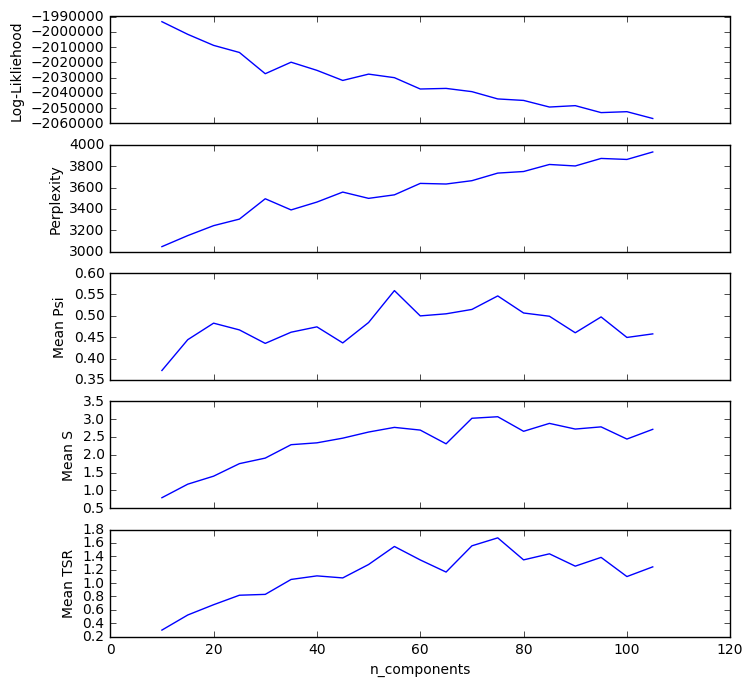

In [8]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(8,8))
ylabs = ['Log-Likliehood', 'Perplexity', 'Mean Psi', 'Mean S', 'Mean TSR']
for i, ax in enumerate(axes.flatten()):
    ax.plot(X, Ym[i])
    ax.set_ylabel(ylabs[i])
    if i == len(axes.flatten())-1:
        ax.set_xlabel('n_components')
plt.show()